In [1]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA

seed = 42
np.random.seed(seed)
random.seed(seed)
data = datasets.load_digits()


X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def evaluate_bagging_sa(n_trees, ratio):
    bagging_sa = BaggingSA(X=X_train, y=y_train,
                                T0=10, alpha=0.99, cooling_method= 'geometric', max_iterations=2000, n_trees=n_trees,
                                fitness_accuracy_diversity_ratio=ratio,
                                feature_mutation_chance=0.3, test_split_amount=20)
    models = bagging_sa.run(X_for_test=X_test, y_for_test=y_test, monitor_fun=fun_monitor)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy, models


fit_acc_sum = {}
best_fitness_global = -1

def fun_monitor(iteration, T, best_fitness, fitness, new_fitness, accuracy):
    # print(f"I: {iteration}, T: {T:.3f}, Best fitness: {best_fitness:.3f}, Fitness: {fitness:.3f}, New fitness: {new_fitness:.3f}, Accuracy: {accuracy:.3f}")
    if new_fitness not in fit_acc_sum:
        fit_acc_sum[new_fitness] = [accuracy]
    else:
        fit_acc_sum[new_fitness].append(accuracy)
    global best_fitness_global
    best_fitness_global = best_fitness


In [3]:
import time


fitness_accuracy_disagreement_ratios = [.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
reps = 3
n_tees = 10

results = []
for ratio in fitness_accuracy_disagreement_ratios:
    for rep in range(reps):
        print(f"Ratio: {ratio}, Rep: {rep}")
        start_time = time.time()
        global best_fitness_global, fit_acc_sum
        fit_acc_sum = {}
        best_fitness_global = -1
        acc, models = evaluate_bagging_sa(n_trees=n_tees, ratio=ratio)
        end_time = time.time()
        X = np.array(list(fit_acc_sum.keys()))
        Y = np.array([np.mean(fit_acc_sum[x]) for x in X])
        correlation = np.corrcoef(X, Y)[0, 1]
        print(f"    Done in {(end_time - start_time)/60:.2f} min | Accuracy: {acc:.3f} | Best fitness: {best_fitness_global:.3f} | Correlation: {correlation:.3f}")
        results.append([ratio, rep, acc, correlation, best_fitness_global])
        df = pd.DataFrame(results, columns=['fitness_accuracy_disagreement_ratio', 'rep', 'accuracy', 'correlation', 'best_fitness'])
        df.to_csv('./../res/bagging_sa_correlation.csv', index=False)

Ratio: 0.0, Rep: 0
    Done in 3.53 min | Accuracy: 0.817 | Best fitness: 1.000 | Correlation: -0.010
Ratio: 0.0, Rep: 1
    Done in 4.50 min | Accuracy: 0.850 | Best fitness: 1.000 | Correlation: -0.066
Ratio: 0.0, Rep: 2
    Done in 5.01 min | Accuracy: 0.806 | Best fitness: 1.000 | Correlation: -0.064
Ratio: 0.1, Rep: 0
    Done in 5.15 min | Accuracy: 0.917 | Best fitness: 0.991 | Correlation: 0.229
Ratio: 0.1, Rep: 1
    Done in 4.79 min | Accuracy: 0.856 | Best fitness: 0.991 | Correlation: 0.216
Ratio: 0.1, Rep: 2
    Done in 4.13 min | Accuracy: 0.911 | Best fitness: 0.990 | Correlation: 0.125
Ratio: 0.2, Rep: 0
    Done in 4.70 min | Accuracy: 0.875 | Best fitness: 0.977 | Correlation: 0.295
Ratio: 0.2, Rep: 1
    Done in 5.02 min | Accuracy: 0.911 | Best fitness: 0.985 | Correlation: 0.603
Ratio: 0.2, Rep: 2
    Done in 4.67 min | Accuracy: 0.878 | Best fitness: 0.983 | Correlation: 0.286
Ratio: 0.3, Rep: 0
    Done in 3.18 min | Accuracy: 0.875 | Best fitness: 0.980 | Correl

In [4]:
df = pd.read_csv('./../res/bagging_sa_correlation.csv')

df_grouped = df.groupby('fitness_accuracy_disagreement_ratio').agg(
    fitnessDisagreementRatio = ('fitness_accuracy_disagreement_ratio', 'mean'),
    accuracyMean = ('accuracy', 'mean'),
    accuracyStd = ('accuracy', 'std'),
    correlationMean = ('correlation', 'mean'),
    correlationStd = ('correlation', 'std'),
    bestFitnessMean = ('best_fitness', 'mean'),
    bestFitnessStd = ('best_fitness', 'std'),
).reset_index()

df_grouped.to_csv('./../res/bagging_sa_correlation_grouped.csv', index=False)

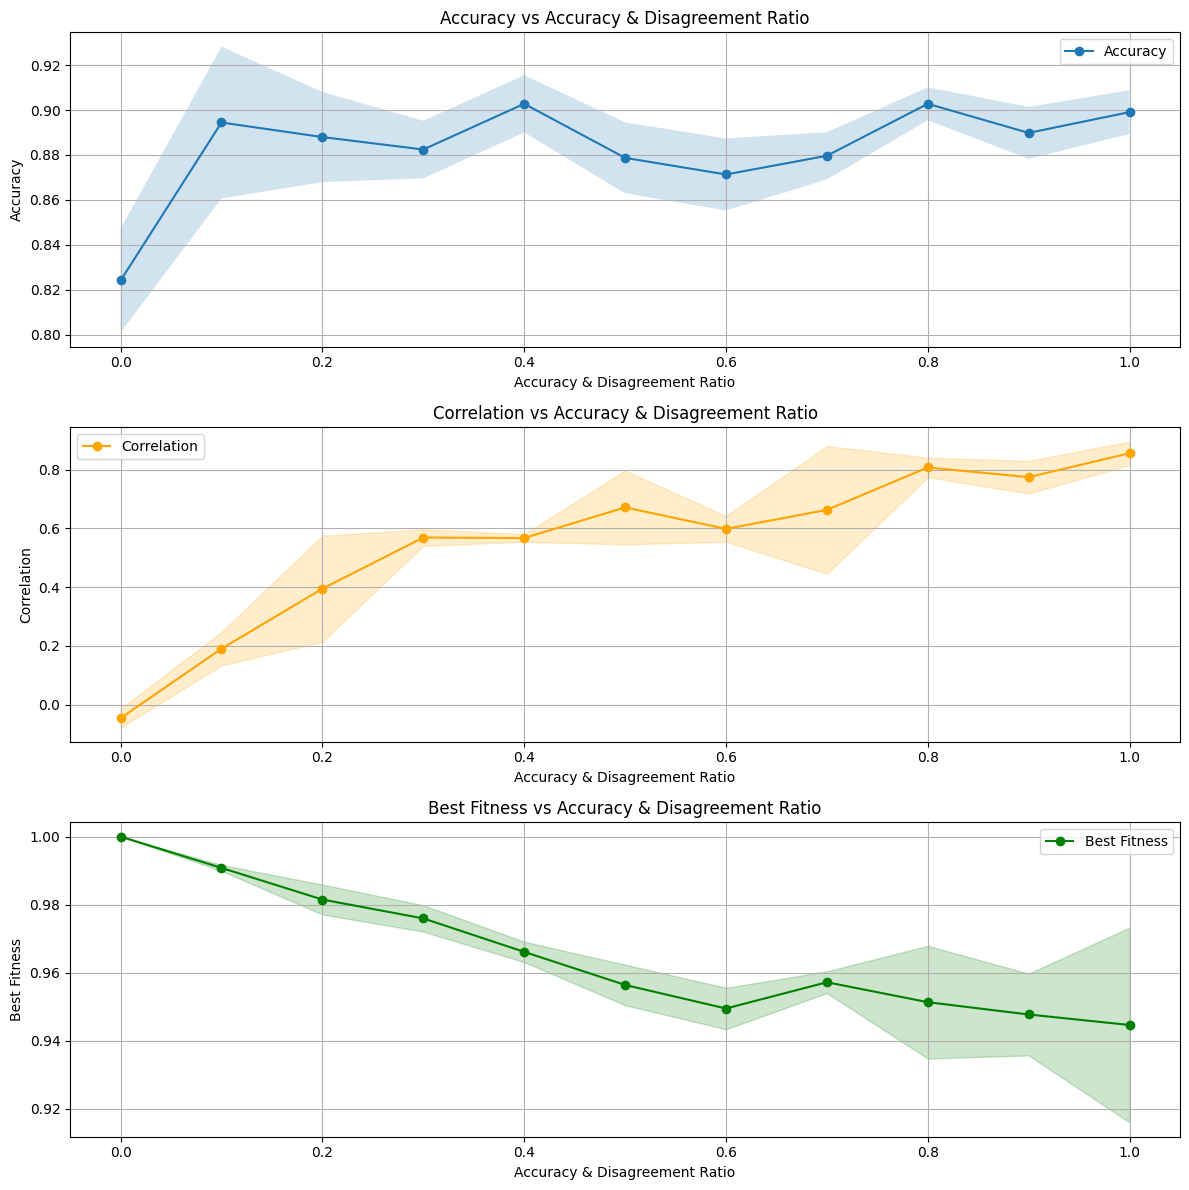

In [5]:
from matplotlib import pyplot as plt

df = pd.read_csv('./../res/bagging_sa_correlation_grouped.csv')

X = df['fitnessDisagreementRatio']
Y1 = df['accuracyMean']
Y1_std = df['accuracyStd']
Y2 = df['correlationMean']
Y2_std = df['correlationStd']
Y3 = df['bestFitnessMean']
Y3_std = df['bestFitnessStd']

df = pd.read_csv('./../res/bagging_sa_correlation_grouped.csv')
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].plot(X, Y1, marker='o', label='Accuracy')
axs[0].fill_between(X, Y1 - Y1_std, Y1 + Y1_std, alpha=0.2)
axs[0].set_title('Accuracy vs Accuracy & Disagreement Ratio')
axs[0].set_xlabel('Accuracy & Disagreement Ratio')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid()

axs[1].plot(X, Y2, marker='o', label='Correlation', color='orange')
axs[1].fill_between(X, Y2 - Y2_std, Y2 + Y2_std, alpha=0.2, color='orange')
axs[1].set_title('Correlation vs Accuracy & Disagreement Ratio')
axs[1].set_xlabel('Accuracy & Disagreement Ratio')
axs[1].set_ylabel('Correlation')
axs[1].legend()
axs[1].grid()

axs[2].plot(X, Y3, marker='o', label='Best Fitness', color='green')
axs[2].fill_between(X, Y3 - Y3_std, Y3 + Y3_std, alpha=0.2, color='green')
axs[2].set_title('Best Fitness vs Accuracy & Disagreement Ratio')
axs[2].set_xlabel('Accuracy & Disagreement Ratio')
axs[2].set_ylabel('Best Fitness')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
# plt.savefig('./../res/bagging_sa_correlation.png', dpi=300)
plt.show()